In [1]:
!pip install nilearn
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 25.8 MB/s eta 0:00:00
/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [2]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00


In [30]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx



In [4]:
import networkx as nx
from networkx.convert_matrix import from_numpy_array

# **Data preparation**

Set up for our learning task by getting the data we need from the raw fMRI time courses.

[Nilearn](https://nilearn.github.io/stable/index.html) is a great piece of open source software that has the utility functions needed to do this!

![](https://i.imgur.com/vyyZA9t.png)

Create the directories that our dataset will be saved in.

In [5]:
dataset_path = 'dataset'
corr_matrices_dir = f'{dataset_path}/corr_matrices'
pcorr_matrices_dir = f'{dataset_path}/pcorr_matrices'
avg_pcorr_file = f'{dataset_path}/avg_pcorr.csv'
time_series_dir = f'{dataset_path}/time_series'
labels_file = f'{dataset_path}/labels.csv'

os.makedirs(corr_matrices_dir)
os.makedirs(pcorr_matrices_dir)
os.makedirs(time_series_dir)

Fetch an atlas that parcellates the brain into regions of interest (ROIs), and fetch the raw fMRI data from OpenNeuro.

[Link](https://openneuro.org/datasets/ds000228/versions/1.1.0) to dataset.

In [6]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps
atlas_labels = atlas.labels

data = datasets.fetch_development_fmri()


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.



Dataset created in /root/nilearn_data/development_fmri


Added README.md to /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (5 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (5 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (5 seconds, 0 min)


 ...done. (5 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


Extract signal in each ROI over time using the atlas we just created.

In [14]:
# standardize=True means signals in time series signals are shifted to zero mean and scaled to unit variance
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache')

time_series = [0] * len(data.func)
labels = [0] * len(data.func)

for i in range(0, len(data.func)):
    sub_num = int(data.phenotypic[i][0][9:]) - 1

    ts = masker.fit_transform(data.func[i], confounds=data.confounds[i])
    time_series[sub_num] = ts
    labels[sub_num] = data.phenotypic[i][3]

# Save time series
for i in range(len(time_series)):
  np.savetxt(f'{time_series_dir}/time_series_{i:04d}.csv', time_series[i], delimiter=',')

/usr/local/lib/python3.10/dist-packages/nilearn/maskers/base_masker.py:268: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


Calculating partial correlation matrix for each time series and taking the mean. This will serve as the basis for edges in the graphs we create later.



In [15]:
corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

# Get average partial correlation matrix across time series and save
avg_pcorr_matrix = np.mean(pcorr_matrices, axis=0)
np.savetxt(avg_pcorr_file, avg_pcorr_matrix, delimiter=',')

# Save correlation and partial correlation matrices
for i in range(0, len(corr_matrices)):
    np.savetxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', corr_matrices[i], delimiter=',')
    np.savetxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', pcorr_matrices[i], delimiter=',')

# Save labels
label_nums = [0 if label == 'child' else 1 for label in labels]
np.savetxt(labels_file, np.asarray(label_nums).astype(int), delimiter=',')

Let's visualize a functional connectome!

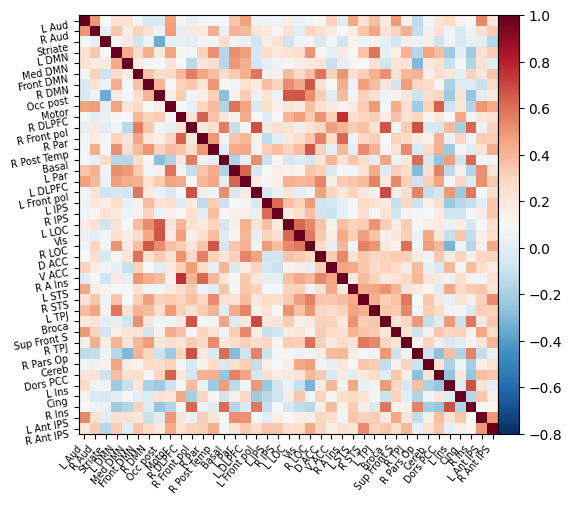

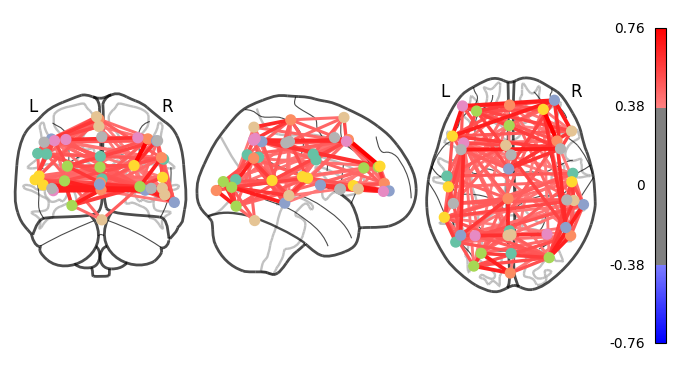

In [16]:
# Partial correlation matrix
plotting.plot_matrix(corr_matrices[0], labels=atlas_labels, colorbar=True, vmax=1, vmin=-0.8)

# Connectome over brain schematic
coords = atlas.region_coords # Get center coordinates of each ROI
plotting.plot_connectome(corr_matrices[0], coords, edge_threshold="80%", colorbar=True)

Define a custom class for our dataset.

To build the graphs, we load up the partial correlation matrices we calculated earlier. Edges are formed between ROIs and their non-zero correlates.

Then we grab our correlation matrices and use them as features for our graphs.

In [17]:
from torch_geometric.data import InMemoryDataset, Data
import os
import torch
import numpy as np
import networkx as nx

class DevDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbors=10):
        self.neighbors = neighbors
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Paths of connectivity matrices
        corr_path_list = sorted(os.listdir(corr_matrices_dir), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dir), key=lambda x: int(x[-8:-4]))

        graphs = []
        labels = torch.from_numpy(np.loadtxt(labels_file, delimiter=','))
        for i in range(0, len(corr_path_list)):
            corr_matrix_path = os.path.join(corr_matrices_dir, corr_path_list[i])
            pcorr_matrix_path = os.path.join(pcorr_matrices_dir, pcorr_path_list[i])

            # Pushing partial correlation matrices through the pipeline to get the final Data object
            pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')

            index = np.abs(pcorr_matrix_np).argsort(axis=1)
            n_rois = pcorr_matrix_np.shape[0]

            # Take only the top k correlates to reduce the number of edges
            for j in range(n_rois):
                for k in range(n_rois - self.neighbors):
                    pcorr_matrix_np[j, index[j, k]] = 0
                for k in range(n_rois - self.neighbors, n_rois):
                    pcorr_matrix_np[j, index[j, k]] = 1

            # Create a NetworkX graph from the NumPy matrix
            pcorr_matrix_nx = nx.Graph(pcorr_matrix_np)

            # Convert NetworkX graph to PyTorch Geometric Data object
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

            # Correlation matrix which will serve as our features
            corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')
            pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)

            # Add to the running list of all dataset items
            graphs.append(pcorr_matrix_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])


In [18]:
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

# **Model definition**

Define simplified [cGCN](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7935029/) model class.

In the cGCN paper, the authors construct a sequence of graphs for each subject, each corresponding to a different step in their time series. We take the partial correlation matrix for all subjects and pick the k most influential connections as edges for each ROI.

![](https://i.imgur.com/uDalqlP.png)

*Wang et al.*

In [41]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())

        # Initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')
        self.conv3 = EdgeConv(self.mlp3, aggr='max')

        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)

        return x

# Training

Final training steps for our model.

In [42]:
import torch

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 01, Loss: -0.6521, Train: 80.65%, Test: 70.97%
Epoch: 02, Loss: -0.8169, Train: 83.87%, Test: 70.97%
Epoch: 03, Loss: -0.9260, Train: 81.45%, Test: 70.97%
Epoch: 04, Loss: -0.8899, Train: 81.45%, Test: 70.97%
Epoch: 05, Loss: -0.9383, Train: 85.48%, Test: 74.19%
Epoch: 06, Loss: -0.9455, Train: 92.74%, Test: 77.42%
Epoch: 07, Loss: -0.9961, Train: 90.32%, Test: 70.97%
Epoch: 08, Loss: -0.9599, Train: 96.77%, Test: 74.19%
Epoch: 09, Loss: -0.9880, Train: 98.39%, Test: 83.87%
Epoch: 10, Loss: -0.9915, Train: 99.19%, Test: 90.32%
Epoch: 11, Loss: -0.9619, Train: 99.19%, Test: 93.55%
Epoch: 12, Loss: -0.9986, Train: 99.19%, Test: 93.55%
Epoch: 13, Loss: -0.9992, Train: 99.19%, Test: 93.55%
Epoch: 14, Loss: -0.9985, Train: 99.19%, Test: 93.55%
Epoch: 15, Loss: -0.9991, Train: 99.19%, Test: 93.55%
Epoch: 16, Loss: -0.9994, Train: 99.19%, Test: 96.77%
Epoch: 17, Loss: -0.9623, Train: 99.19%, Test: 100.00%
Epoch: 18, Loss: -0.9996, Train: 99.19%, Test: 93.55%
Epoch: 19, Loss: -0.9998, T

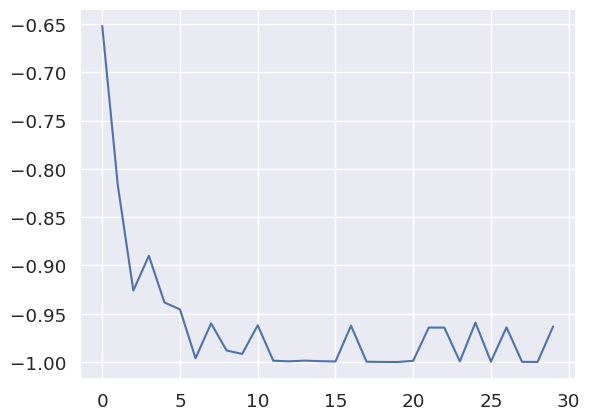

In [43]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ Performs an epoch of model training.

    Parameters:
    model (nn.Module): Model to be trained.
    loss_fn (nn.Module): Loss function for training.
    device (torch.Device): Device used for training.
    data_loader (torch.utils.data.DataLoader): Data loader containing all batches.
    optimizer (torch.optim.Optimizer): Optimizer used to update model.

    Returns:
    float: Total loss for epoch.
    """
    model.train()
    loss = 0

    for batch in data_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)

        loss = loss_fn(out, batch.y)

        loss.backward()
        optimizer.step()

    return loss.item()

def eval(model, device, loader):
    """ Calculate accuracy for all examples in a DataLoader.

    Parameters:
    model (nn.Module): Model to be evaluated.
    device (torch.Device): Device used for training.
    loader (torch.utils.data.DataLoader): DataLoader containing examples to test.
    """
    model.eval()
    cor = 0
    tot = 0

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]

    return cor / tot




    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 30):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_result = eval(model, device, train_loader)
    test_result = eval(model, device, test_loader)

    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_result:.2f}%, '
          f'Test: {100 * test_result:.2f}%')

plt.plot(losses)
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test dataset to get predictions and true labels
def evaluate_model(model, device, loader):
    model.eval()
    predictions = []
    true_labels = []

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        predictions.extend(pred.cpu().numpy())
        true_labels.extend(batch.y.cpu().numpy())

    return predictions, true_labels

# Get predictions and true labels
test_predictions, test_labels = evaluate_model(model, device, test_loader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Generate classification report
class_report = classification_report(test_labels, test_predictions)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[22  0]
 [ 2  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.78      0.88         9

    accuracy                           0.94        31
   macro avg       0.96      0.89      0.92        31
weighted avg       0.94      0.94      0.93        31



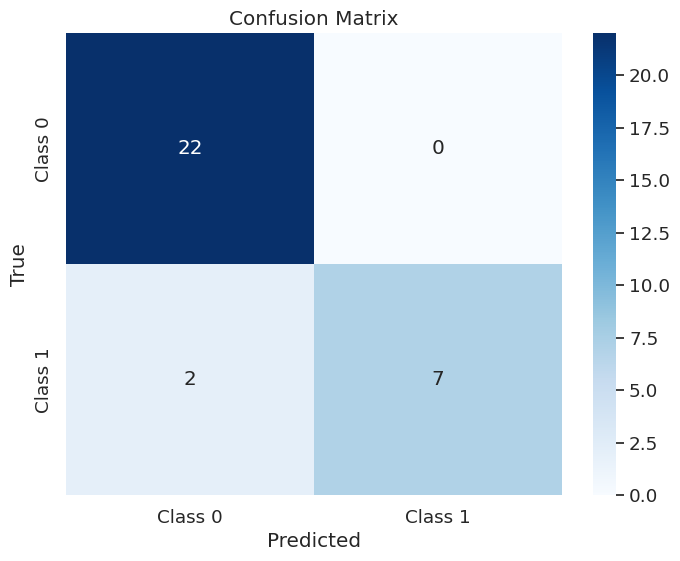

In [45]:
classes = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**MULTINET GRAPH**

In [27]:
class MultinetGraphNetwork(torch.nn.Module):
    def __init__(self, hidden_channels, num_networks):
        super().__init__()

        self.num_networks = num_networks
        self.gcn_branches = torch.nn.ModuleList()

        for _ in range(num_networks):
            # Initialize MLPs used by EdgeConv layers for each branch
            mlp = Sequential(
                Linear(2 * dataset.num_node_features, hidden_channels),
                ReLU(),  # ReLU activation should be part of the Sequential module
            )
            conv = EdgeConv(mlp, aggr='max')
            bn = torch.nn.BatchNorm1d(hidden_channels)

            self.gcn_branches.append(conv)  # Only add the conv layer to the branches
            self.gcn_branches.append(bn)     # Add the BatchNorm layer
            self.gcn_branches.append(mlp)    # Add the MLP module as well

        self.linear = torch.nn.Linear(hidden_channels * num_networks, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        branch_outputs = []

        for i in range(0, len(self.gcn_branches), 3):  # Iterate with step 3
            conv = self.gcn_branches[i]
            bn = self.gcn_branches[i+1]
            mlp = self.gcn_branches[i+2]

            x_temp = x.clone()  # Create a copy of node features for each branch
            x_temp = conv(x_temp, edge_index)
            x_temp = bn(x_temp)
            x_temp = F.relu(x_temp)

            branch_outputs.append(x_temp)

        x = torch.cat(branch_outputs, dim=1)  # Concatenate outputs from all branches
        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)

        return x



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 01, Loss: 0.5964, Train Accuracy: 80.65%, Test Accuracy: 70.97%
Epoch: 02, Loss: 0.4809, Train Accuracy: 80.65%, Test Accuracy: 70.97%
Epoch: 03, Loss: 0.4623, Train Accuracy: 80.65%, Test Accuracy: 70.97%
Epoch: 04, Loss: 0.4180, Train Accuracy: 85.48%, Test Accuracy: 74.19%
Epoch: 05, Loss: 0.3997, Train Accuracy: 93.55%, Test Accuracy: 90.32%
Epoch: 06, Loss: 0.3743, Train Accuracy: 97.58%, Test Accuracy: 93.55%
Epoch: 07, Loss: 0.3632, Train Accuracy: 97.58%, Test Accuracy: 90.32%
Epoch: 08, Loss: 0.3522, Train Accuracy: 97.58%, Test Accuracy: 93.55%
Epoch: 09, Loss: 0.3490, Train Accuracy: 97.58%, Test Accuracy: 93.55%
Epoch: 10, Loss: 0.3442, Train Accuracy: 97.58%, Test Accuracy: 93.55%
Epoch: 11, Loss: 0.3431, Train Accuracy: 97.58%, Test Accuracy: 93.55%
Epoch: 12, Loss: 0.3381, Train Accuracy: 97.58%, Test Accuracy: 90.32%
Epoch: 13, Loss: 0.3427, Train Accuracy: 97.58%, Test Accuracy: 90.32%
Epoch: 14, Loss: 0.3360, Train Accuracy: 98.39%, Test Accuracy: 93.55%
Epoch:

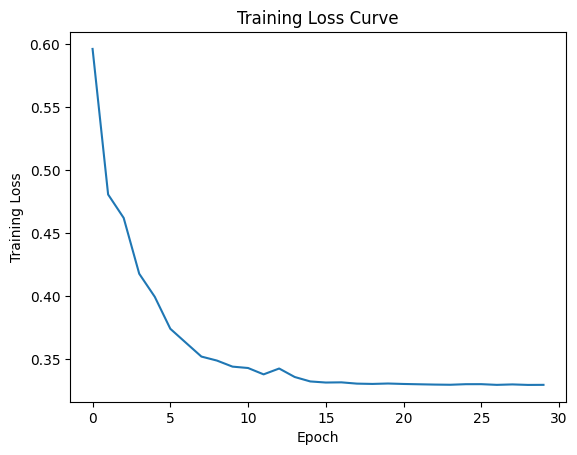

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

def train_multinet(model, loss_fn, optimizer, device, train_loader):
    """
    Trains the MultinetGraphNetwork model for one epoch.

    Parameters:
        model (MultinetGraphNetwork): The MultinetGraphNetwork model to be trained.
        loss_fn (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
        device (torch.device): The device (CPU or GPU) to perform training.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.

    Returns:
        float: Total loss for the epoch.
    """
    model.train()
    total_loss = 0.0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)  # Update here
        loss = loss_fn(outputs, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs  # Accumulate the total loss

    return total_loss / len(train_loader.dataset)

def eval_multinet(model, device, loader):
    """ Calculate accuracy for all examples in a DataLoader.

    Parameters:
    model (nn.Module): Model to be evaluated.
    device (torch.device): Device used for evaluation.
    loader (torch.utils.data.DataLoader): DataLoader containing examples to evaluate.

    Returns:
    float: Accuracy of the model on the given data.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultinetGraphNetwork(hidden_channels=32, num_networks=3).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
loss_fn = torch.nn.CrossEntropyLoss()
losses = []
for epoch in range(30):
    train_loss = train_multinet(model, loss_fn, optimizer, device, train_loader)

    train_acc = eval_multinet(model, device, train_loader)
    test_acc = eval_multinet(model, device, test_loader)

    losses.append(train_loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_acc * 100:.2f}%, '
          f'Test Accuracy: {test_acc * 100:.2f}%')

# Plotting losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test dataset to get predictions and true labels
def evaluate_model(model, device, loader):
    model.eval()
    predictions = []
    true_labels = []

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        predictions.extend(pred.cpu().numpy())
        true_labels.extend(batch.y.cpu().numpy())

    return predictions, true_labels

# Get predictions and true labels
test_predictions, test_labels = evaluate_model(model, device, test_loader)

# Calculate confusion matrix
conf_matrix1 = confusion_matrix(test_labels, test_predictions)

# Generate classification report
class_report = classification_report(test_labels, test_predictions)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix1)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[22  0]
 [ 1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.89      0.94         9

    accuracy                           0.97        31
   macro avg       0.98      0.94      0.96        31
weighted avg       0.97      0.97      0.97        31



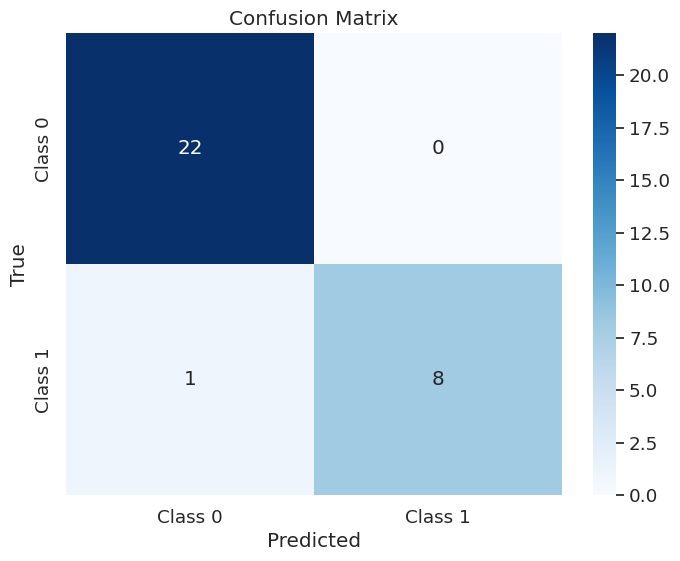

In [35]:
classes = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale for better readability
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()